# SquirrelXAI: Photorealistic Inpainting for Explainability

This notebook runs a full perturbation-based explainability pipeline with three experiments:

1. **Experiment 1 – Object Removal (SAM masks)**  
2. **Experiment 2 – Object Replacement (SAM masks)**  
3. **Experiment 3 – Background Replacement (SAM masks)**  

Stages shared across all experiments:
- Stage 1: YOLOv9 Detection
- Stage 2: Mask Generation (bbox + SAM)
- Stage 3: Inpainting (different modes)
- Stage 4: Detection-based Perturbation Analysis
- Stage 5: Visualizations


## Setup and Imports


In [45]:
import os
import json
import sys
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cv2
from PIL import Image

# Add current directory to path
sys.path.append(".")

# Import our modules
from detect import detect_squirrels
from generate_masks import generate_masks_from_detections
from inpaint import batch_inpaint, test_backend
from perturbation_analysis import analyze_perturbations
from visualize import generate_all_visualizations

print("Setup complete!")

Setup complete!


In [46]:
import torch

print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print(
    "MPS (Mac GPU) available:",
    torch.backends.mps.is_available() if hasattr(torch.backends, "mps") else False,
)
print(
    "MPS built:",
    torch.backends.mps.is_built() if hasattr(torch.backends, "mps") else False,
)

# Determine best device
if torch.cuda.is_available():
    device = "cuda"
elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

print(f"\n✓ Using device: {device}")

PyTorch version: 2.6.0
CUDA available: False
MPS (Mac GPU) available: True
MPS built: True

✓ Using device: mps


## Configuration


In [48]:
import os
import json
import matplotlib.pyplot as plt

from detect import detect_squirrels
from generate_masks import generate_masks_from_detections
from inpaint import batch_inpaint
from perturbation_analysis import analyze_perturbations
from visualize import generate_all_visualizations

MODEL_PATH = "model/best.pt"
TEST_IMAGES_DIR = "squirrel_data/test/images"

OUTPUTS_DIR = "outputs"
DETECTIONS_DIR = os.path.join(OUTPUTS_DIR, "detections")
SAM_MASKS_DIR = os.path.join(OUTPUTS_DIR, "sam_masks")  # shared across experiments

os.makedirs(DETECTIONS_DIR, exist_ok=True)
os.makedirs(SAM_MASKS_DIR, exist_ok=True)

## Stage 1: YOLOv9 Detection

Detect squirrels in test images using the trained YOLOv9 model.


In [49]:
print("Stage 1: Running YOLOv9 detection...")
detections = detect_squirrels(
    model_path=MODEL_PATH,
    images_dir=TEST_IMAGES_DIR,
    output_dir=DETECTIONS_DIR,
    conf_threshold=0.25,
)

print(f"\nDetected squirrels in {len(detections)} images")
total_detections = sum(r["num_detections"] for r in detections.values())
print(f"Total detections: {total_detections}")

Stage 1: Running YOLOv9 detection...
Loading YOLOv9 model from model/best.pt...
Found 64 images to process


Detecting squirrels: 100%|██████████| 64/64 [00:18<00:00,  3.47it/s]


Detection complete! Results saved to outputs/detections/detections.json
Total images processed: 64
Total detections: 79

Detected squirrels in 64 images
Total detections: 79


### Save detection images

In [50]:
from ultralytics import YOLO
import os

model_path = "model/best.pt"
model = YOLO(model_path)
import os

# Path to test images
test_img_dir = "squirrel_data/test/images"

# Loop through and predict
for file in os.listdir(test_img_dir):
    if file.endswith((".jpg", ".png")):
        image_path = os.path.join(test_img_dir, file)
        results = model.predict(image_path, save=True, conf=0.25)


image 1/1 /Users/tusunaiturumbekova/SquirrelXAI-Photorealistic-Inpainting-for-Object-Level-Model-Explanations/squirrel_data/test/images/9d807b0f20e78202_jpg.rf.87f986d3258c2d11d67293730ff18dec.jpg: 640x640 1 Squirrel, 325.0ms
Speed: 1.0ms preprocess, 325.0ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)
Results saved to /Users/tusunaiturumbekova/SquirrelXAI-Photorealistic-Inpainting-for-Object-Level-Model-Explanations/runs/detect/predict5

image 1/1 /Users/tusunaiturumbekova/SquirrelXAI-Photorealistic-Inpainting-for-Object-Level-Model-Explanations/squirrel_data/test/images/s_321_jpg.rf.492bbea7376b5b83a65bfddb6613b992.jpg: 640x640 1 Squirrel, 284.2ms
Speed: 0.7ms preprocess, 284.2ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)
Results saved to /Users/tusunaiturumbekova/SquirrelXAI-Photorealistic-Inpainting-for-Object-Level-Model-Explanations/runs/detect/predict5

image 1/1 /Users/tusunaiturumbekova/SquirrelXAI-Photorealistic-Inpainting-for-Object

### Let's see one example

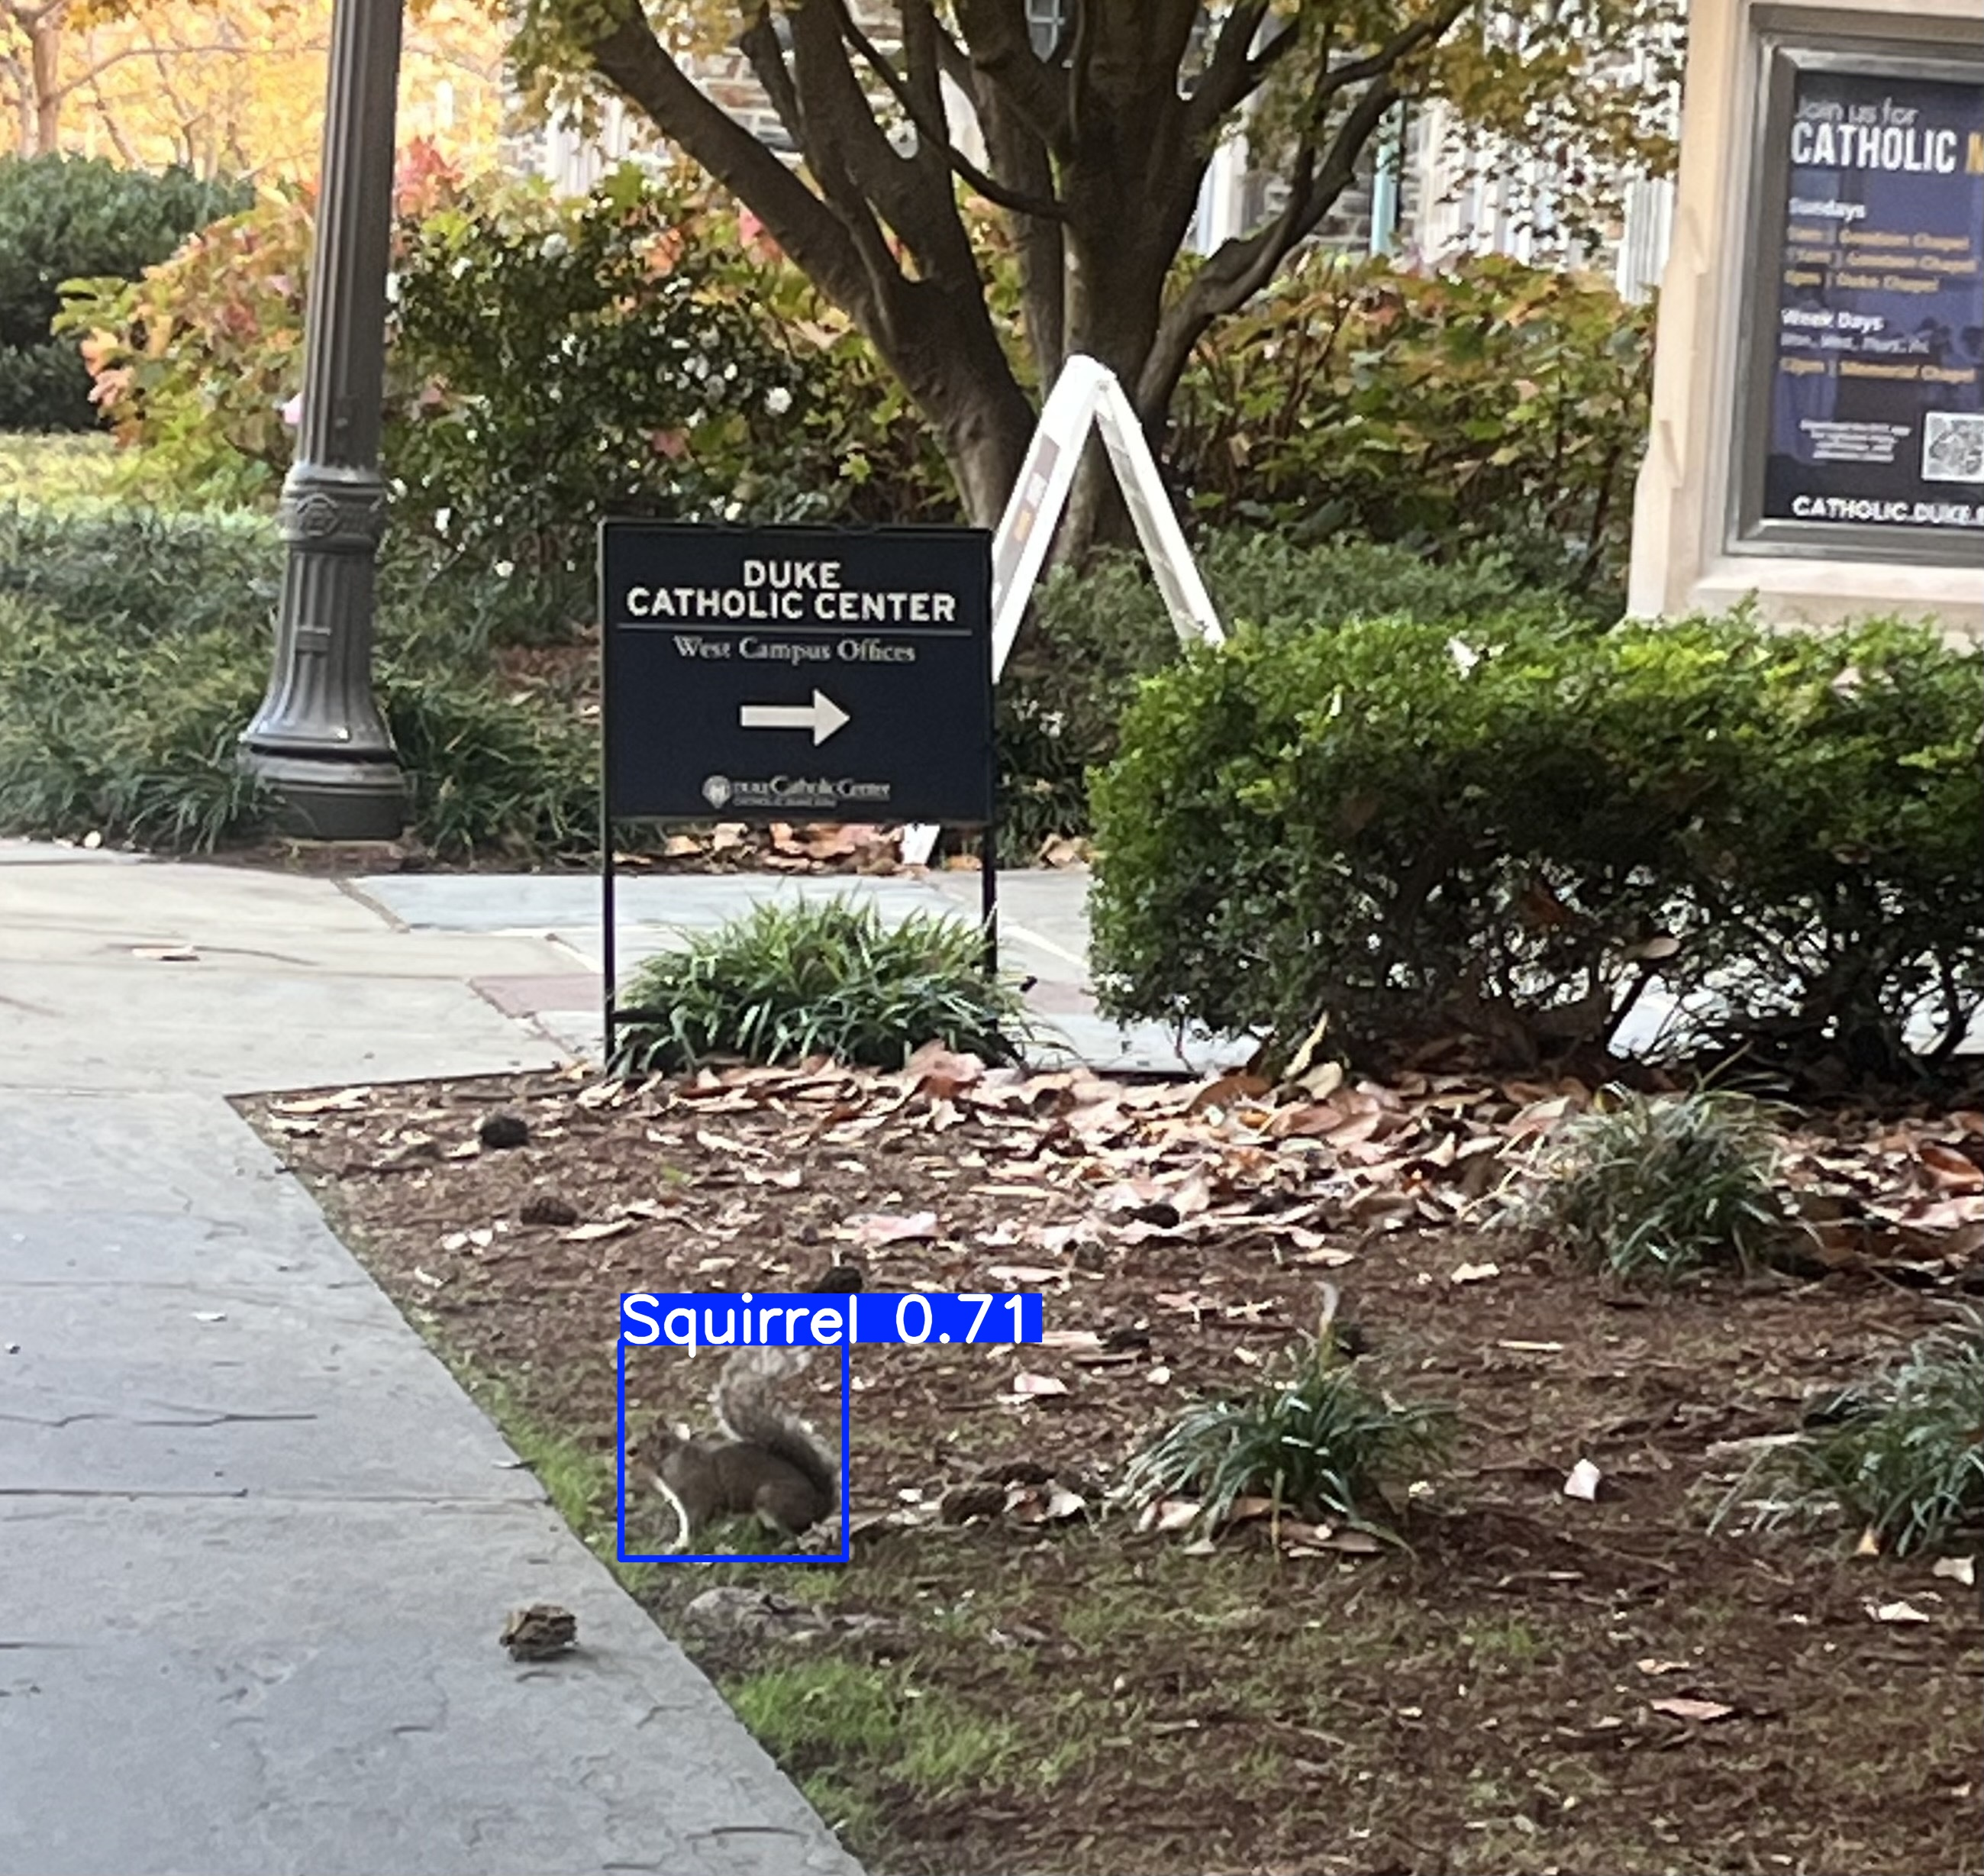

In [51]:
from IPython.display import Image, display

# Show one of the predicted images
result_img_path = "runs/detect/predict/Duke3.jpg"  # Adjust filename
display(Image(filename=result_img_path))

## Stage 2: Mask Generation

Generate segmentation masks from bounding boxes or SAM. Optionally use existing masks if available.


In [ ]:
print("Stage 2: Generating SAM masks...")

detections_json = os.path.join(DETECTIONS_DIR, "detections.json")
sam_mask_paths = generate_masks_from_detections(
    detections_json=detections_json,
    images_dir=TEST_IMAGES_DIR,
    output_dir=SAM_MASKS_DIR,
    use_existing_masks=None,
    use_sam=True,
    sam_checkpoint="sam/sam_vit_b.pth",
    sam_model_type="vit_b",
)
print(f"SAM masks generated: {len(sam_mask_paths)}")

Stage 2: Generating SAM masks...
[SAM] Loading model 'vit_b' on device: mps


Generating masks: 100%|██████████| 64/64 [01:19<00:00,  1.25s/it]


Mask generation complete! Masks saved to outputs/sam_masks
Total masks generated: 64
SAM masks generated: 64


**Check SAM masking**

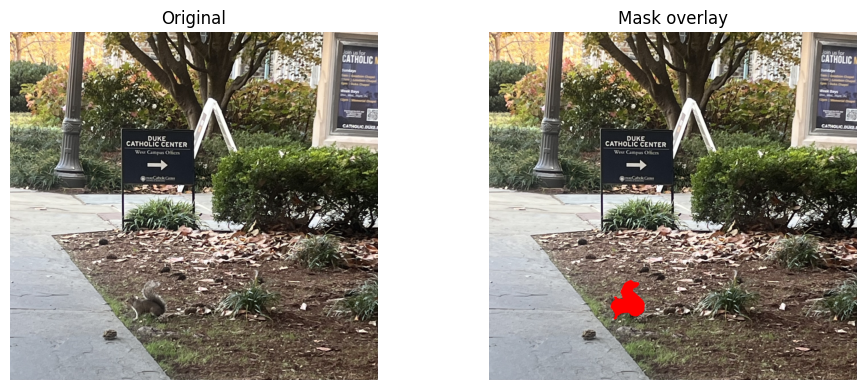

In [ ]:
import cv2

example = "Duke3"  # pick a filename that actually exists

mask_path = os.path.join(SAM_MASKS_DIR, example + "_mask.png")
img_path = os.path.join(TEST_IMAGES_DIR, example + ".jpg")

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
img = cv2.imread(img_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.title("Original")
plt.imshow(img_rgb)
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Mask overlay")
overlay = img_rgb.copy()
overlay[mask > 0] = [255, 0, 0]  # red squirrel region
plt.imshow(overlay)
plt.axis("off")

plt.tight_layout()
plt.show()

In [ ]:
# print("Stage 2: Generating masks...")

# # Bounding-box-based masks (only need to run once if you care about bbox)
# MASKING_METHOD = "bbox"
# METHOD_TAG = "bbox"
# MASKS_DIR = os.path.join(OUTPUTS_DIR, METHOD_TAG, "masks")

# os.makedirs(MASKS_DIR, exist_ok=True)

# detections_json = os.path.join(DETECTIONS_DIR, "detections.json")
# generate_masks_from_detections(
#     detections_json=detections_json,
#     images_dir=TEST_IMAGES_DIR,
#     output_dir=MASKS_DIR,
#     use_existing_masks=None,
# )

## Experiments set up

In [54]:
import os

os.environ["REPLICATE_API_TOKEN"] = (
    "r8_9JdQ7UANdlMQ7Q94RIJH7pauByjMo4v2p2797"  # Replace with your token
)
print("✓ API token set")

✓ API token set


In [ ]:
def run_experiment(
    experiment_name: str,
    prompt: str,
    negative_prompt: str,
    invert_mask: bool = False,
    extra_label: str = "",
    delay_between_requests: float = 12.0,
):
    """
    Run inpainting + analysis + visualization for a single experiment.

    experiment_name -> used as folder name under outputs/
    invert_mask=True -> background replacement
    """
    experiment_root = os.path.join(OUTPUTS_DIR, experiment_name)
    inpainted_dir = os.path.join(experiment_root, "inpainted")
    analysis_dir = os.path.join(experiment_root, "analysis")
    visuals_dir = os.path.join(experiment_root, "final_visuals")

    for d in [experiment_root, inpainted_dir, analysis_dir, visuals_dir]:
        os.makedirs(d, exist_ok=True)

    print("=" * 80)
    print(f"Running experiment: {experiment_name} {extra_label}")
    print("=" * 80)

    # --- Stage 3: Inpainting ---
    mask_paths_json = os.path.join(SAM_MASKS_DIR, "mask_paths.json")
    inpainted_paths = batch_inpaint(
        mask_paths_json=mask_paths_json,
        images_dir=TEST_IMAGES_DIR,
        output_dir=inpainted_dir,
        backend="stable_diffusion",
        prompt=prompt,
        negative_prompt=negative_prompt,
        delay_between_requests=delay_between_requests,
        max_retries=3,
        invert_mask=invert_mask,  # you'll add this arg in inpaint.py (see below)
    )
    inpainted_paths_json = os.path.join(
        inpainted_dir, "stable_diffusion", "inpainted_paths.json"
    )

    # --- Stage 4: Analysis ---
    detections_json = os.path.join(DETECTIONS_DIR, "detections.json")
    df, summary = analyze_perturbations(
        detections_json=detections_json,
        original_images_dir=TEST_IMAGES_DIR,
        inpainted_paths_json=inpainted_paths_json,
        yolo_model_path=MODEL_PATH,
        output_dir=analysis_dir,
        conf_threshold=0.25,
    )

    # --- Stage 5: Visualizations ---
    analysis_csv = os.path.join(analysis_dir, "perturbation_analysis.csv")
    mask_paths_json = os.path.join(SAM_MASKS_DIR, "mask_paths.json")

    generate_all_visualizations(
        detections_json=detections_json,
        mask_paths_json=mask_paths_json,
        inpainted_paths_json=inpainted_paths_json,
        analysis_csv=analysis_csv,
        original_images_dir=TEST_IMAGES_DIR,
        output_dir=visuals_dir,
    )

    print(f"Experiment {experiment_name} complete.")
    print(f"  Root: {experiment_root}")
    return experiment_root

## Experiment 1: Object Removal (SAM Masks)

We remove the squirrel by inpainting inside the SAM mask with a natural background.
This is our main baseline experiment.


In [59]:
import importlib
import inpaint

importlib.reload(inpaint)
from inpaint import batch_inpaint, test_backend

METHOD_TAG = "sam"
MASKS_DIR = os.path.join(OUTPUTS_DIR, METHOD_TAG, "masks")


exp1_root = run_experiment(
    experiment_name="sam_object_removal",
    prompt="seamless natural background, consistent lighting, no animals",
    negative_prompt="duplicate, distortion, artifacts, low quality",
    invert_mask=False,
    extra_label="(SAM masks, remove squirrel)",
)

Running experiment: sam_object_removal (SAM masks, remove squirrel)


Inpainting with stable_diffusion: 100%|██████████| 64/64 [16:00<00:00, 15.00s/it]



Inpainting complete! Results saved to outputs/sam_object_removal/inpainted/stable_diffusion
Total images inpainted: 64
Analyzing perturbations using YOLOv9 detection...
Processing 64 image pairs...
Verifying original image detections...


Running YOLO detection: 100%|██████████| 64/64 [00:20<00:00,  3.18it/s]


Running YOLOv9 detection on inpainted images...


Running YOLO detection: 100%|██████████| 64/64 [00:19<00:00,  3.35it/s]



Analysis complete! Results saved to outputs/sam_object_removal/analysis
Mean detection drop: 0.78
Mean detection removal rate: 61.98%
All detections removed: 40/64 (62.50%)
Mean avg confidence drop: 0.4706
Generating visualizations...


Creating visualizations: 100%|██████████| 64/64 [00:33<00:00,  1.89it/s]


Summary plots saved to outputs/sam_object_removal/final_visuals

All visualizations saved to outputs/sam_object_removal/final_visuals
Experiment sam_object_removal complete.
  Root: outputs/sam_object_removal


## Experiment 2: Object Replacement (SAM Masks)

We replace the squirrel with a neutral object (rock / stump / log) inside the SAM mask.
This tests whether YOLOv9 is sensitive to the **semantics** of the foreground object.


In [62]:
prompt_obj = (
    "a small rock or tree stump or wooden log in the same location, "
    "natural outdoor scene, consistent lighting, photorealistic"
)
neg_prompt_obj = "squirrel, animal, person, distortion, artifacts, low quality"

exp2_root = run_experiment(
    experiment_name="sam_object_replacement",
    prompt="a small stone or log on the ground, natural outdoor setting, realistic lighting",
    negative_prompt="animal, squirrel, distortion, artifacts, low quality",
    invert_mask=False,  # still editing the object region
    extra_label="(SAM masks, replace squirrel with log/stone)",
)

Running experiment: sam_object_replacement (SAM masks, replace squirrel with log/stone)


Inpainting with stable_diffusion:  17%|█▋        | 11/64 [02:25<09:13, 10.45s/it]

Error during inpainting: NSFW content detected. Try running it again, or try a different prompt.

⚠ Rate limited. Waiting 24.0s before retry 1/3...


Inpainting with stable_diffusion:  41%|████      | 26/64 [06:17<06:48, 10.74s/it]

Error during inpainting: NSFW content detected. Try running it again, or try a different prompt.

⚠ Rate limited. Waiting 24.0s before retry 1/3...


Inpainting with stable_diffusion: 100%|██████████| 64/64 [15:51<00:00, 14.86s/it]



Inpainting complete! Results saved to outputs/sam_object_replacement/inpainted/stable_diffusion
Total images inpainted: 62
Analyzing perturbations using YOLOv9 detection...
Processing 62 image pairs...
Verifying original image detections...


Running YOLO detection: 100%|██████████| 62/62 [00:16<00:00,  3.87it/s]


Running YOLOv9 detection on inpainted images...


Running YOLO detection: 100%|██████████| 62/62 [00:15<00:00,  3.89it/s]



Analysis complete! Results saved to outputs/sam_object_replacement/analysis
Mean detection drop: 0.92
Mean detection removal rate: 69.09%
All detections removed: 43/62 (69.35%)
Mean avg confidence drop: 0.5493
Generating visualizations...


Creating visualizations: 100%|██████████| 62/62 [00:30<00:00,  2.03it/s]


Summary plots saved to outputs/sam_object_replacement/final_visuals

All visualizations saved to outputs/sam_object_replacement/final_visuals
Experiment sam_object_replacement complete.
  Root: outputs/sam_object_replacement


## Experiment 3: Background Replacement (SAM Masks)

Here we keep the squirrel and replace only the **background** by inpainting the inverted SAM mask.
This tests how much YOLOv9 relies on background context vs. the object itself.


In [64]:
prompt_bg = (
    "a natural outdoor background, park or forest, consistent lighting, "
    "no people, photorealistic"
)
neg_prompt_bg = "distortion, artifacts, low quality"

exp3_root = run_experiment(
    experiment_name="sam_background_replacement",
    prompt="a forest path with trees and leaves, natural daylight, depth of field",
    negative_prompt="squirrel, animal, distortion, artifacts, low quality",
    invert_mask=True,  # background edited, squirrel region preserved
    extra_label="(SAM masks, new background)",
)

Running experiment: sam_background_replacement (SAM masks, new background)


Inpainting with stable_diffusion: 100%|██████████| 64/64 [15:30<00:00, 14.54s/it]



Inpainting complete! Results saved to outputs/sam_background_replacement/inpainted/stable_diffusion
Total images inpainted: 64
Analyzing perturbations using YOLOv9 detection...
Processing 64 image pairs...
Verifying original image detections...


Running YOLO detection: 100%|██████████| 64/64 [00:17<00:00,  3.59it/s]


Running YOLOv9 detection on inpainted images...


Running YOLO detection: 100%|██████████| 64/64 [00:17<00:00,  3.58it/s]



Analysis complete! Results saved to outputs/sam_background_replacement/analysis
Mean detection drop: 0.38
Mean detection removal rate: 21.88%
All detections removed: 28/64 (43.75%)
Mean avg confidence drop: 0.4182
Generating visualizations...


Creating visualizations: 100%|██████████| 64/64 [00:32<00:00,  2.00it/s]


Summary plots saved to outputs/sam_background_replacement/final_visuals

All visualizations saved to outputs/sam_background_replacement/final_visuals
Experiment sam_background_replacement complete.
  Root: outputs/sam_background_replacement


## Results Summary

Display key findings from the explainability analysis.

In [ ]:
def show_experiment_summary_and_examples(
    experiment_root: str,
    experiment_label: str,
    target_names=None,
):
    analysis_dir = os.path.join(experiment_root, "analysis")
    visuals_dir = os.path.join(experiment_root, "final_visuals")

    summary_path = os.path.join(analysis_dir, "summary.json")
    if not os.path.exists(summary_path):
        print(f"summary.json not found at: {summary_path}")
        return

    with open(summary_path, "r") as f:
        summary = json.load(f)

    mean_det_removal_rate = summary.get("mean_detection_removal_rate")
    all_removed_rate = summary.get("all_removed_rate")
    if all_removed_rate is None:
        all_removed_rate = summary.get(
            "FLIP_RATE", summary["total_all_removed"] / summary["total_images"]
        )
    partial_removal_rate = summary.get("partial_removal_rate")
    if partial_removal_rate is None and "total_partial_removal" in summary:
        partial_removal_rate = (
            summary["total_partial_removal"] / summary["total_images"]
        )

    print("=" * 60)
    print("EXPLAINABILITY ANALYSIS SUMMARY (YOLOv9 Detection)")
    print(f"Experiment: {experiment_label}")
    print("=" * 60)
    print(f"Total Images Analyzed: {summary['total_images']}")
    print("\nDetection Metrics:")
    print(f"  Mean Detection Drop: {summary['mean_detection_drop']:.2f} detections")
    if mean_det_removal_rate is not None:
        print(f"  Mean Detection Removal Rate: {mean_det_removal_rate:.2%}")
    print(
        f"  All Detections Removed: {summary['total_all_removed']}/{summary['total_images']} "
        f"({all_removed_rate:.2%})"
    )
    if partial_removal_rate is not None:
        print(
            f"  Partial Removal: {summary['total_partial_removal']}/{summary['total_images']} "
            f"({partial_removal_rate:.2%})"
        )
    print("\nConfidence Metrics:")
    print(f"  Mean Avg Confidence Drop: {summary['mean_avg_confidence_drop']:.4f}")
    print(f"  Mean Max Confidence Drop: {summary['mean_max_confidence_drop']:.4f}")
    print("\nAverage Detections:")
    print(f"  Original Images: {summary['mean_original_detections']:.2f}")
    print(f"  Inpainted Images: {summary['mean_inpainted_detections']:.2f}")
    print("=" * 60)
    print(f"Results stored in: {experiment_root}")

    # Example visuals
    individual_dir = os.path.join(visuals_dir, "individual")
    if not os.path.isdir(individual_dir):
        print(f"\nNo 'individual' visuals directory found at: {individual_dir}")
        return

    if target_names is None:
        target_names = [
            "831a4c1638a4dc07_jpg.rf.677672b99caf72fcd69b67362f1a6bfd_visualization",
            "Duke3_visualization",
            "Duke1_visualization",
            "Duke4_visualization",
        ]

    selected_files = []
    for name in target_names:
        for ext in [".png", ".jpg", ".jpeg"]:
            fname = name + ext
            fpath = os.path.join(individual_dir, fname)
            if os.path.exists(fpath):
                selected_files.append(fpath)
                break

    if not selected_files:
        print("\nNo target visualization files found in:", individual_dir)
        return

    fig, axes = plt.subplots(
        len(selected_files), 1, figsize=(8, 6 * len(selected_files))
    )
    if len(selected_files) == 1:
        axes = [axes]

    for i, fpath in enumerate(selected_files):
        img = plt.imread(fpath)
        axes[i].imshow(img)
        axes[i].axis("off")
        axes[i].set_title(f"Results for image #{i+1}", fontsize=14)

    plt.tight_layout()
    plt.show()

### Experiment 1 - Object Removal - Results Summary

EXPLAINABILITY ANALYSIS SUMMARY (YOLOv9 Detection)
Experiment: SAM – Object Removal
Total Images Analyzed: 64

Detection Metrics:
  Mean Detection Drop: 0.78 detections
  Mean Detection Removal Rate: 61.98%
  All Detections Removed: 40/64 (62.50%)
  Partial Removal: 4/64 (6.25%)

Confidence Metrics:
  Mean Avg Confidence Drop: 0.4706
  Mean Max Confidence Drop: 0.5011

Average Detections:
  Original Images: 1.23
  Inpainted Images: 0.45
Results stored in: outputs/sam_object_removal


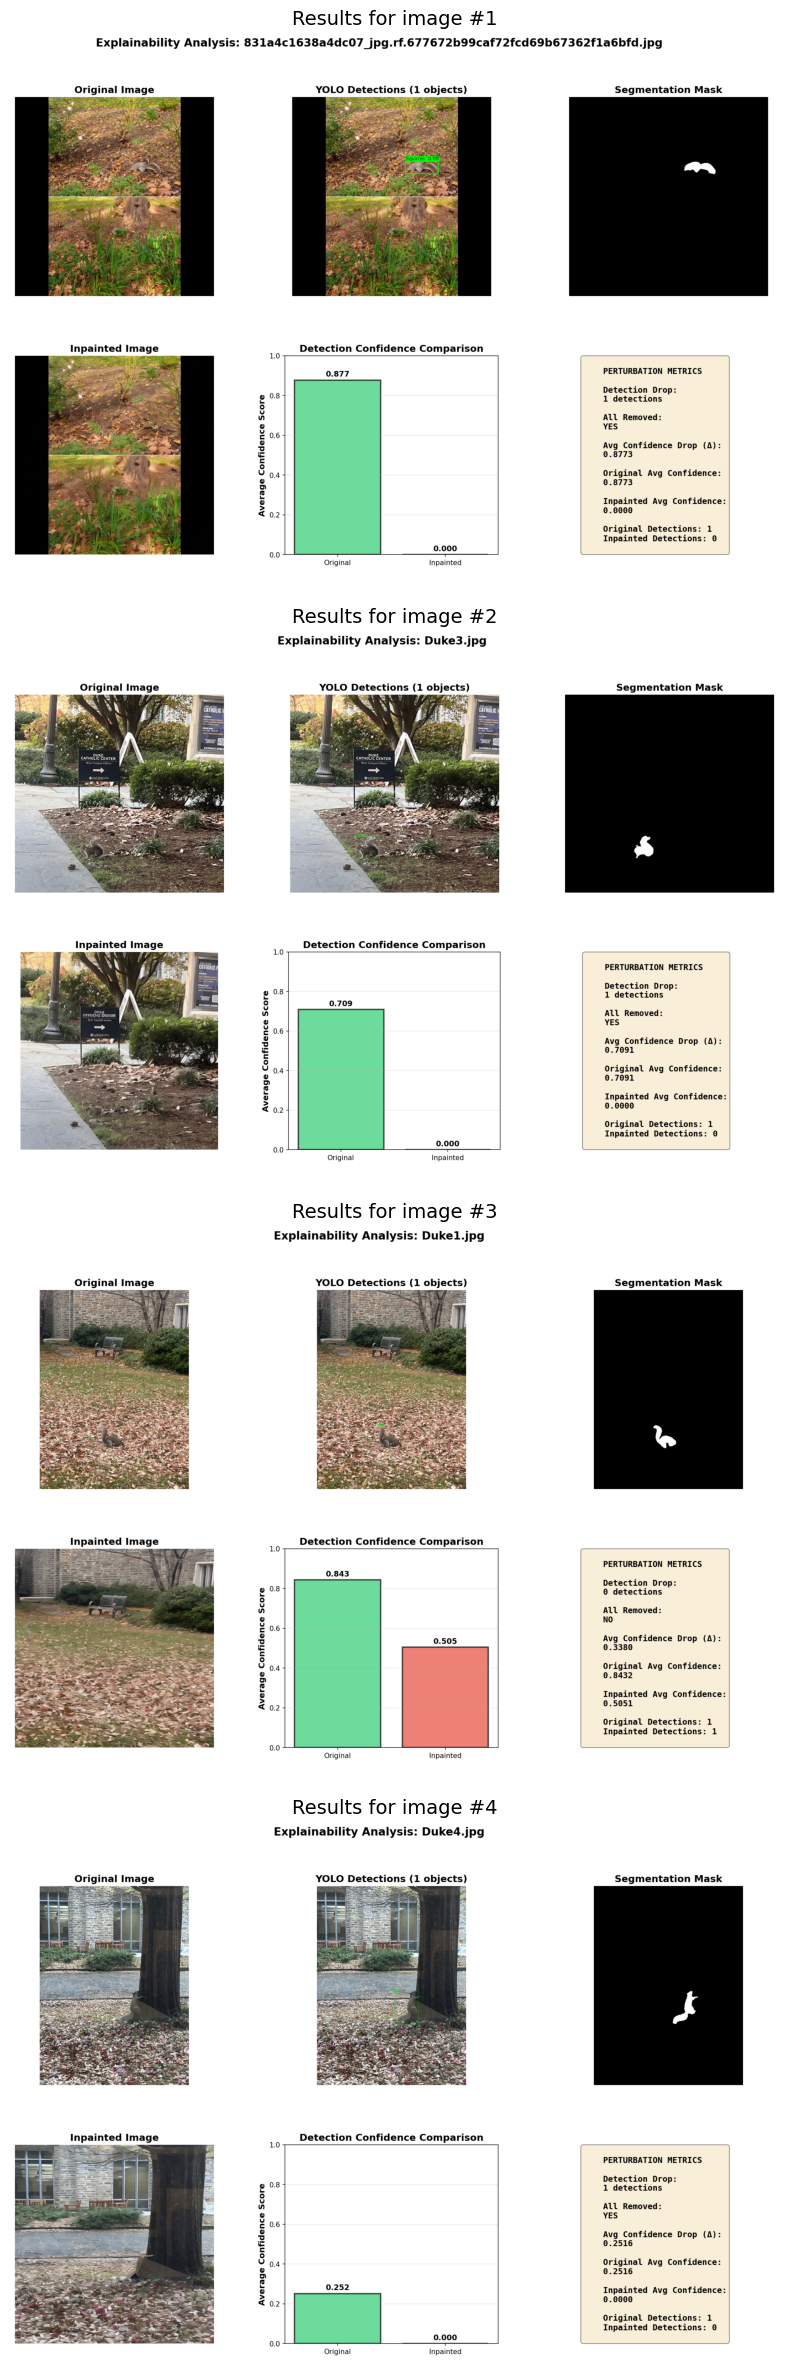

In [ ]:
show_experiment_summary_and_examples(exp1_root, "SAM – Object Removal")

### Experiment 2 - Object Replacement - Results Summary

EXPLAINABILITY ANALYSIS SUMMARY (YOLOv9 Detection)
Experiment: SAM – Object Replacement
Total Images Analyzed: 62

Detection Metrics:
  Mean Detection Drop: 0.92 detections
  Mean Detection Removal Rate: 69.09%
  All Detections Removed: 43/62 (69.35%)
  Partial Removal: 4/62 (6.45%)

Confidence Metrics:
  Mean Avg Confidence Drop: 0.5493
  Mean Max Confidence Drop: 0.5835

Average Detections:
  Original Images: 1.23
  Inpainted Images: 0.31
Results stored in: outputs/sam_object_replacement


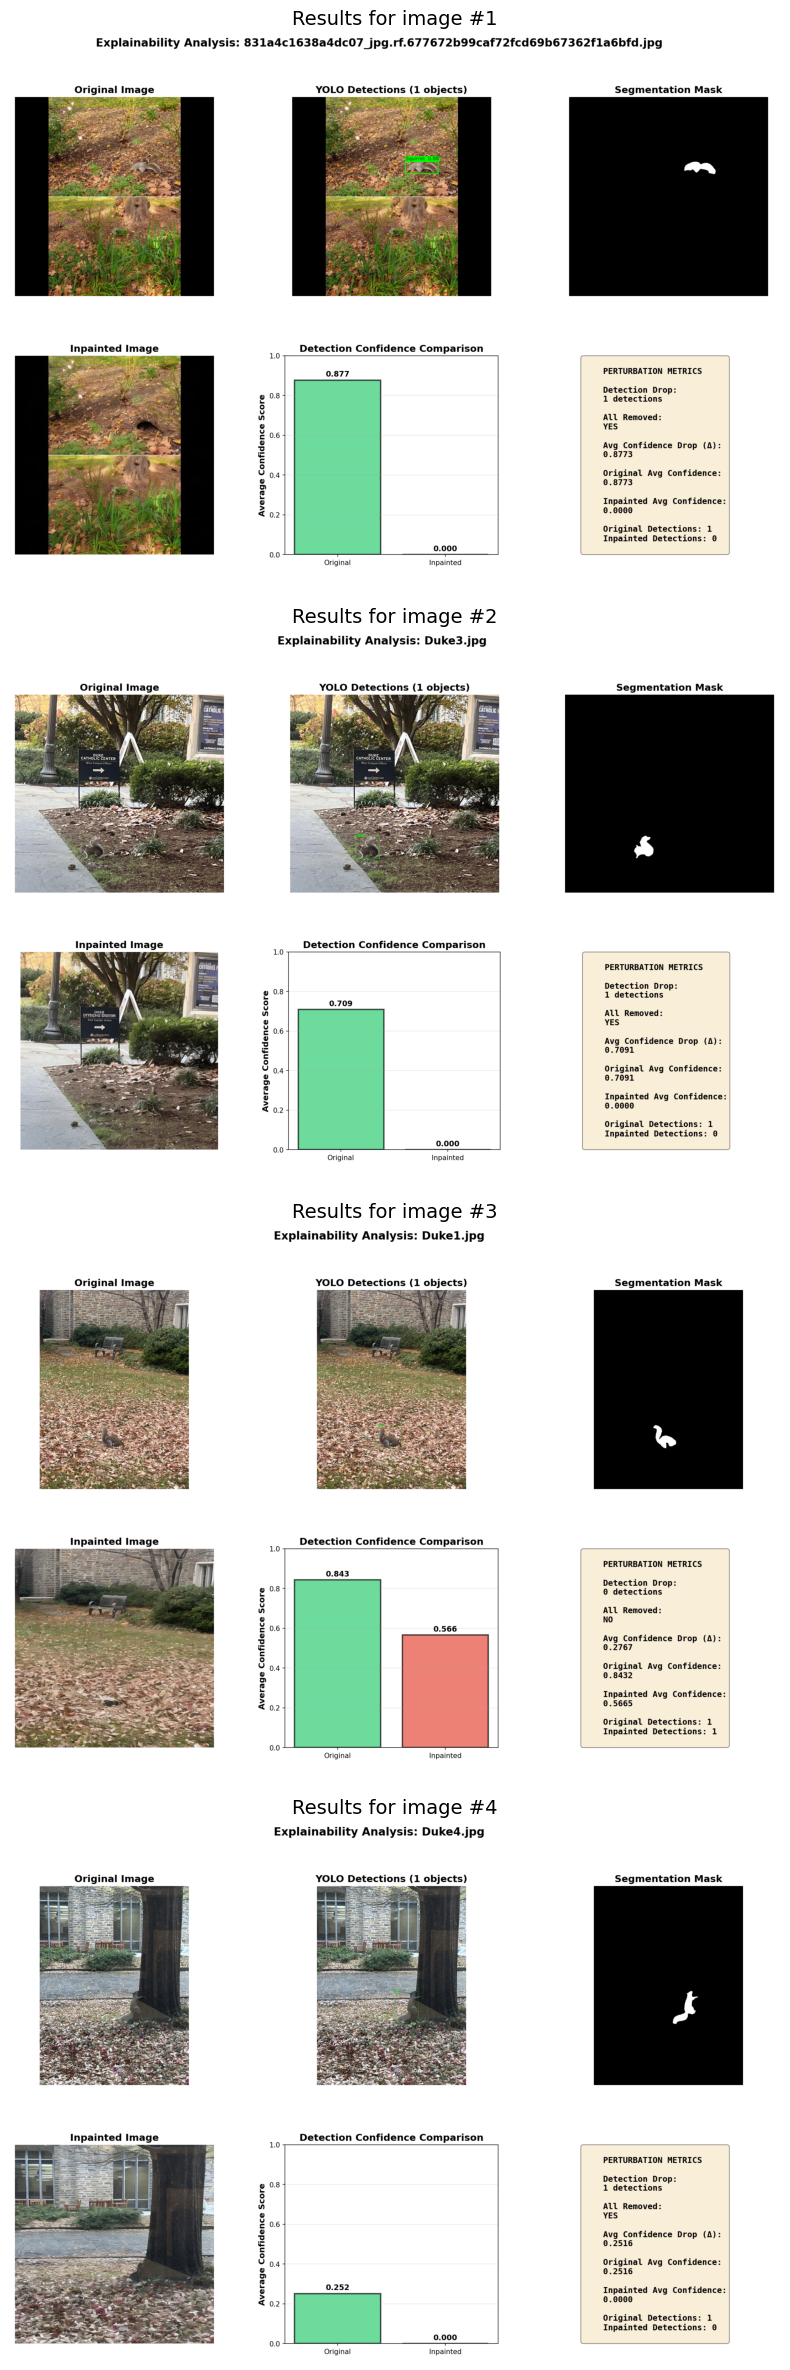

In [63]:
show_experiment_summary_and_examples(exp2_root, "SAM – Object Replacement")

### Experiment 3 - Background Replacement - Results Summary

EXPLAINABILITY ANALYSIS SUMMARY (YOLOv9 Detection)
Experiment: SAM – Background Replacement
Total Images Analyzed: 64

Detection Metrics:
  Mean Detection Drop: 0.38 detections
  Mean Detection Removal Rate: 21.88%
  All Detections Removed: 28/64 (43.75%)
  Partial Removal: 6/64 (9.38%)

Confidence Metrics:
  Mean Avg Confidence Drop: 0.4182
  Mean Max Confidence Drop: 0.4333

Average Detections:
  Original Images: 1.23
  Inpainted Images: 0.86
Results stored in: outputs/sam_background_replacement


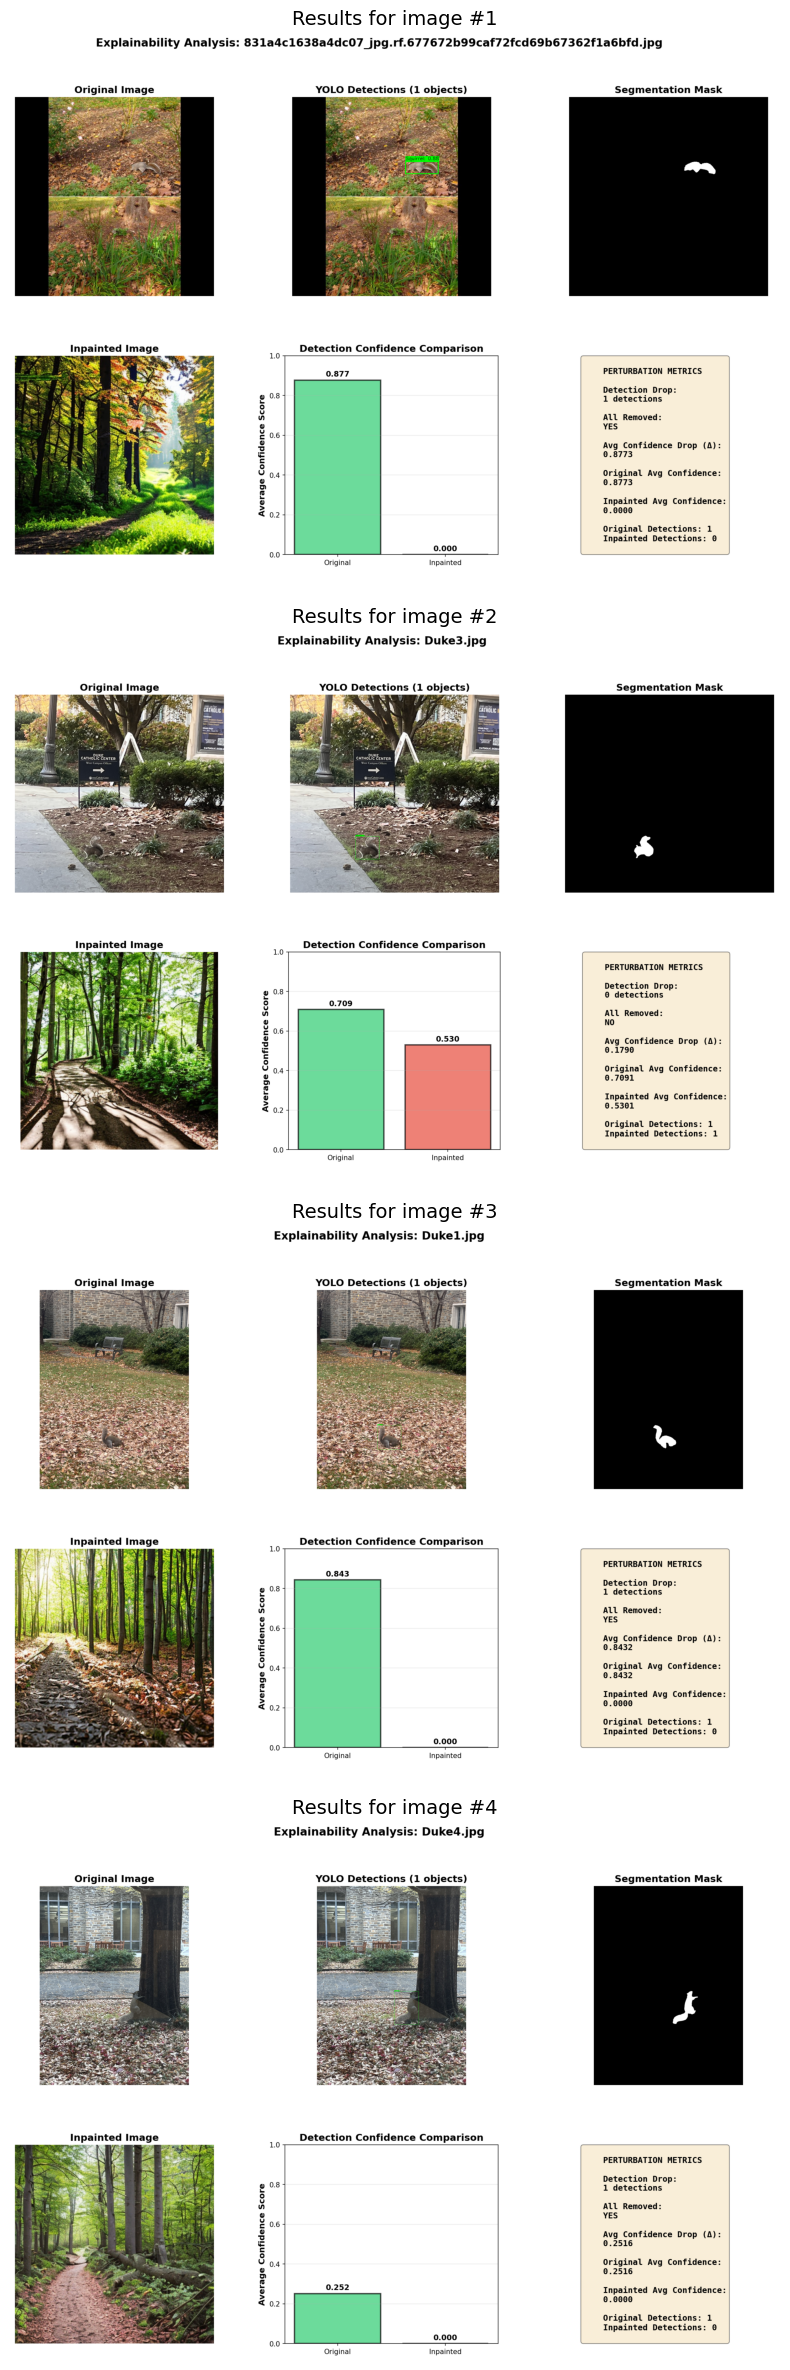

In [65]:
show_experiment_summary_and_examples(exp3_root, "SAM – Background Replacement")